# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pypokerengine.players import BasePokerPlayer
from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
import inspect
from pypokerengine.engine.hand_evaluator import HandEvaluator
from pypokerengine.engine.card import Card


# Honest Player

In [2]:
NB_SIMULATION = 100
class HonestPlayer(BasePokerPlayer):
    def __init__(self, raise_wr = 0.6, call_wr = 0.3):
        super().__init__() 
        self.raise_wr = raise_wr
        self.call_wr = call_wr
        
    def declare_action(self, valid_actions, hole_card, round_state):
        curframe = inspect.currentframe()
        calframe = inspect.getouterframes(curframe, 2)
        community_card = round_state['community_card']
        win_rate = estimate_hole_card_win_rate(
                nb_simulation=NB_SIMULATION,
                nb_player=self.nb_player,
                hole_card=gen_cards(hole_card),
                community_card=gen_cards(community_card)
                )
        if win_rate >= self.raise_wr:
            #print('Raising)', win_rate)
            action = valid_actions[2]  # fetch bet action info
            valid_amounts = action['amount']
            raise_amount =  (valid_amounts['max'] - valid_amounts['min'])/ 5.0 + valid_amounts['min']
            return valid_actions[2]['action'], raise_amount
        elif win_rate >= self.call_wr:
            #print('Calling')
            action = valid_actions[1]  # fetch CALL action info
        else:
            call_amount = valid_actions[1]['amount']
            if(call_amount == 0):
                #print('Calling')
                return valid_actions[1]['action'], valid_actions[1]['amount']
            #print('Folding')
            action = valid_actions[0]  # fetch FOLD action info
        return action['action'], action['amount']

    def receive_game_start_message(self, game_info):
        self.nb_player = game_info['player_num']

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

# My Player

In [81]:
def iterate_actions(hand_data):
    """Iterates over all actions in the 'action_histories' of a given hand.
    
    Args:
    hand_data: A dictionary representing a hand of poker.
    
    Yields:
    A tuple containing the action type, the amount, the player's UUID, and the round.
    """
    if(hand_data):
        for round_name, actions in hand_data['action_histories'].items():
            for action in actions:
                yield (action['action'], action.get('amount'), action['uuid'], round_name)

class BijPlayer(BasePokerPlayer):
    def __init__(self):
        super().__init__() 
        self.player_histories = {}
        self.player_tendencies = {}
        self.hand_evaluator = HandEvaluator()
        self.INVERTED_HAND_STRENGTH_MAP = {value: key for key, value in self.hand_evaluator.HAND_STRENGTH_MAP.items()}
        

        self.player_showdown_score_histories = {}
        self.player_showdown_score_metrics = {}

        self.player_states = []

    def make_score(self, ri):
        hand_strength = self.INVERTED_HAND_STRENGTH_MAP[ri['hand']['strength']]
        hand_high = ri['hand']['high']
        hand_low = ri['hand']['low']
        hole_high = ri['hole']['high']
        hole_low = ri['hole']['low']
        return (hand_strength << 8) | (hand_high << 12) | (hand_low << 8) | (hole_high << 4) | hole_low

        
    def declare_action(self, valid_actions, hole_card, round_state):        
        community_cards = [Card.from_str(c) for c in round_state['community_card']]
        hole_cards = [Card.from_str(c) for c in hole_card]

        my_hand_rank_info = self.hand_evaluator.gen_hand_rank_info(hole_cards, community_cards)
        my_hand_score = self.make_score(my_hand_rank_info)


        participating_players = [player for player in round_state['seats'] if(player['state'] == 'participating')]

        # Determine how many their showdowns we can beat
        matchups = []
        call_amount = valid_actions[1]['amount']
        max_bet_amount = valid_actions[2]['amount']['max']
        candidate_bets = np.linspace(call_amount, max_bet_amount)
        # win/los = (player_idx, showdown_idx)
        # fold = (player_idx, bet_idx, showdown_idx)
        
        for opponent in participating_players:
            opponent_showdown_history = self.player_showdown_score_histories[opponent['uuid']]
            matchup_my_win = np.zeros((len(opponent_showdown_history)))
            matchup_they_fold = np.zeros((len(candidate_bets), len(opponent_showdown_history)))
            
            for showdown_idx, showdown in enumerate(opponent_showdown_history):
                if(my_hand_score >= showdown['score']):
                    matchup_my_win[showdown_idx] = 1
                else:
                    matchup_my_win[showdown_idx] = 0
                 
                for bet_idx, bet_size in enumerate(candidate_bets):
                    if((bet_size / showdown['pot']) > (showdown['pot'] / showdown['cost'])):
                         matchup_they_fold[bet_idx, showdown_idx] = 1
                    else:
                        matchup_they_fold[bet_idx, showdown_idx] = 0
                

            # Save matchups
            matchups += [(matchup_my_win, matchup_they_fold)]
        print('Matchups: ', matchups)

        # For each bet size, we sample 10 matchups from each player and calculate their value. The avg is the expected value
        for bet_idx, bet_size in enumerate(candidate_bets):
            # (sample_idx)
            they_fold_samples = []
            for matchup_my_win, matchup_they_fold in matchups:
                # sample 10 folds for each
                sample_idxs = numpy.random.choice(len(matchup_they_fold[bet_idx]), size=n_samples, replace=True)
                they_fold_samples += [matchup_they_fold[bet_idx][sample_idxs]]
                my_win_samples += [matchup_my_win[sample_idxs]]

            # (player_idx, sample_matcup)
            they_fold_samples = np.stack(they_fold_samples, axis=0)
            # (player_idx, sample_matcup)
            my_win_samples = np.stack(my_win_samples, axis=0)
            # Decide whether I win the entire pot (have to beat everyone)
            my_win_pot = np.sum(my_win_samples, axis=0) > 0
            # Decide whether everyone folds or not
            
            
                
                

        # 1) Sample 10 matchups from each player
            
 
        # Expected value of the fold action.
        ev_fold = 0
        # Expected value of the call action.
        #ev_call = calc_ev('call')
        # test
        return valid_actions[1]['action'], valid_actions[1]['amount']

    def receive_game_start_message(self, game_info):
        self.nb_player = game_info['player_num']
        print('game info: ', game_info)
        for seat in game_info['seats']:
            self.player_showdown_score_histories[seat['uuid']] = []
        

    def receive_round_start_message(self, round_count, hole_card, seats):
        print('On round: ', round_count)
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        self.player_states += [round_state['seats'][round_state['next_player']]['state']]
        #pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        #print('Round state: ', round_state)

        print('Hand info: ', hand_info)
        
        print('\n\n')
        showdown_players_uuids = [player['uuid'] for player in round_state['seats'] if(player['state'] == 'participating')]
        folded_players_uuids = [player['uuid'] for player in round_state['seats'] if(player['state'] == 'folded')]

        players_showdown_states = {player['uuid']: player['state'] for player in round_state['seats']}

        print('\nhand info: ', hand_info)
        print('showdown player: ', showdown_players_uuids)

        # Get cost for each player
        player_costs = {}
        for street, player_actions in round_state['action_histories'].items():
            for action in player_actions:
                uuid = action['uuid']
                try:
                    amount = action['amount']
                except KeyError:
                    amount = 0
                try:
                    player_costs[uuid] += amount
                except KeyError:
                    player_costs[uuid] = amount

        # NOTE THIS DOES NOT INCLUDE SIDE POTS
        pot_size = round_state['pot']['main']['amount']
        
        # Record player showdown states (score, cost, pot)
        showdown_player_hands = {player['uuid']: player['hand'] for player in hand_info}
        
        for player_uuid, hand in showdown_player_hands.items():
            hand = showdown_player_hands[player_uuid]
            score = self.make_score(hand)


            cost = player_costs[player_uuid]

            showdown_state = {'score': score, 'pot': pot_size, 'cost': cost}
            try:
                self.player_showdown_score_histories[player_uuid] += [showdown_state]
            except KeyError:
                self.player_showdown_score_histories[player_uuid] = [showdown_state]
            #print(player_uuid, 'Showdown state: ', showdown_state)
    
        print('Showdown histories: ', self.player_showdown_score_histories)

# Run Poker Game

In [82]:
from collections import Counter

results_dict = {'p1': [], 'p2': [], 'p3': [], 'p4': []}
initial_stack = 1000
for i in range(1):
    config = setup_config(max_round=1000, initial_stack=initial_stack, small_blind_amount=5)
    config.register_player(name="p1", algorithm=HonestPlayer())
    config.register_player(name="p2", algorithm=HonestPlayer(raise_wr = 0.9, call_wr=0.7))
    config.register_player(name="p3", algorithm=HonestPlayer(raise_wr = 0.3, call_wr=0.1))
    bijPlayer = BijPlayer()
    config.register_player(name="p4", algorithm=bijPlayer)
    game_result = start_poker(config, verbose=0)
    #print(i, game_result)
    players = game_result['players']
    for player in players:
        results_dict[player['name']] += [player['stack'] - initial_stack]
        
        

print(results_dict)
print(Counter(bijPlayer.player_states))


game info:  {'player_num': 4, 'rule': {'initial_stack': 1000, 'max_round': 1000, 'small_blind_amount': 5, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'p1', 'uuid': 'udvzyvettehfomdbmixmvk', 'stack': 1000, 'state': 'participating'}, {'name': 'p2', 'uuid': 'bnhvxhilpwxhxfusxhopam', 'stack': 1000, 'state': 'participating'}, {'name': 'p3', 'uuid': 'bcdzjksvuvinsfifeffvsv', 'stack': 1000, 'state': 'participating'}, {'name': 'p4', 'uuid': 'nwunrhqnmgvcrhmlzvxfnc', 'stack': 1000, 'state': 'participating'}]}
On round:  1
Matchups:  [(array([], dtype=float64), array([], shape=(50, 0), dtype=float64)), (array([], dtype=float64), array([], shape=(50, 0), dtype=float64)), (array([], dtype=float64), array([], shape=(50, 0), dtype=float64)), (array([], dtype=float64), array([], shape=(50, 0), dtype=float64))]
Matchups:  [(array([], dtype=float64), array([], shape=(50, 0), dtype=float64)), (array([], dtype=float64), array([], shape=(50, 0), dtype=float64))]
Matchups:  [(array([], dtype=floa

# Plot Results

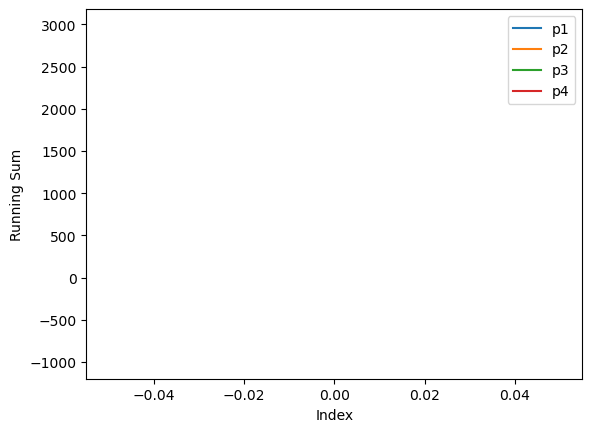

In [5]:

def plot_running_sums(data):
  """Plots the running sums of a dictionary of arrays.

  Args:
    data: A dictionary where the keys are labels and the values are arrays of numbers.
  """

  for label, values in data.items():
    running_sum = np.cumsum(values)
    plt.plot(running_sum, label=label)

  plt.xlabel("Index")
  plt.ylabel("Running Sum")
  plt.legend()
  plt.show()

plot_running_sums(results_dict)

In [83]:
np.random.choice(20, size=10, replace=True)


array([ 5, 12, 10,  1, 19,  5,  1, 15, 10, 13])